In [1]:
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd


# Initial state
state = {
    'ELTK_supply': 100000, 
    'veELTK_supply': 0, 
    'liquidity_providers': 500, 
    'emissions': 40000, 
    'lock_period': 0, 
    'current_time': 0
}

# Simulation parameters
params = {
    'stake_rate': [0.1],  # rate at which new stakes are added
    'unstake_rate': [0.05],  # rate at which stakes are removed
    'lock_period': [1, 2, 3, 4],  # lock period in years
    'emission_rate': [10000]  # amount of emissions per epoch
}

# Policy Functions
def policy_stake(params, step, history, current_state):
    # The amount staked is the stake rate times the current ELTK supply
    amount = params['stake_rate'] * current_state['ELTK_supply']
    return {'stake': amount}

def policy_unstake(params, step, history, current_state):
    # The amount unstaked is the unstake rate times the current veELTK supply
    amount = params['unstake_rate'] * current_state['veELTK_supply']
    return {'unstake': amount}

def policy_claim_rewards(params, step, history, current_state):
    # The rewards claimed are proportional to the amount of veELTK held
    amount = current_state['veELTK_supply'] / current_state['ELTK_supply'] * current_state['emissions']
    return {'claim_rewards': amount}

def update_ELTK_supply(params, step, sL, s, _input):
    y = 'ELTK_supply'
    x = s[y]
    # ELTK is staked (reducing the supply) and unstaked (increasing the supply)
    x = x - _input['stake'] + _input['unstake']
    return (y, x)

def update_veELTK_supply(params, step, sL, s, _input):
    y = 'veELTK_supply'
    x = s[y]
    # veELTK is created when ELTK is staked (increasing the supply) and destroyed when it is unstaked (reducing the supply)
    x = x + _input['stake'] - _input['unstake']
    return (y, x)

def update_emissions(params, step, sL, s, _input):
    y = 'emissions'
    x = s[y]
    # Emissions are reduced when rewards are claimed
    x = x - _input['claim_rewards']
    return (y, x)

partial_state_update_blocks = [
    {
        'policies': {
            'stake': policy_stake,
            'unstake': policy_unstake,
            'claim_rewards': policy_claim_rewards,
        },
        'variables': {
            'ELTK_supply': update_ELTK_supply,
            'veELTK_supply': update_veELTK_supply,
            'emissions': update_emissions,
        }
    }
]
# Simulation parameters
sim_config = {
    'N': 1,  # number of Monte Carlo runs
    'T': range(1000),  # number of timesteps
    'M': params  # model parameters
}

sim_params = config_sim(sim_config)

# Configuring and running the simulation
exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 4, 4, 6)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 4, 4, 6)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 5.52s


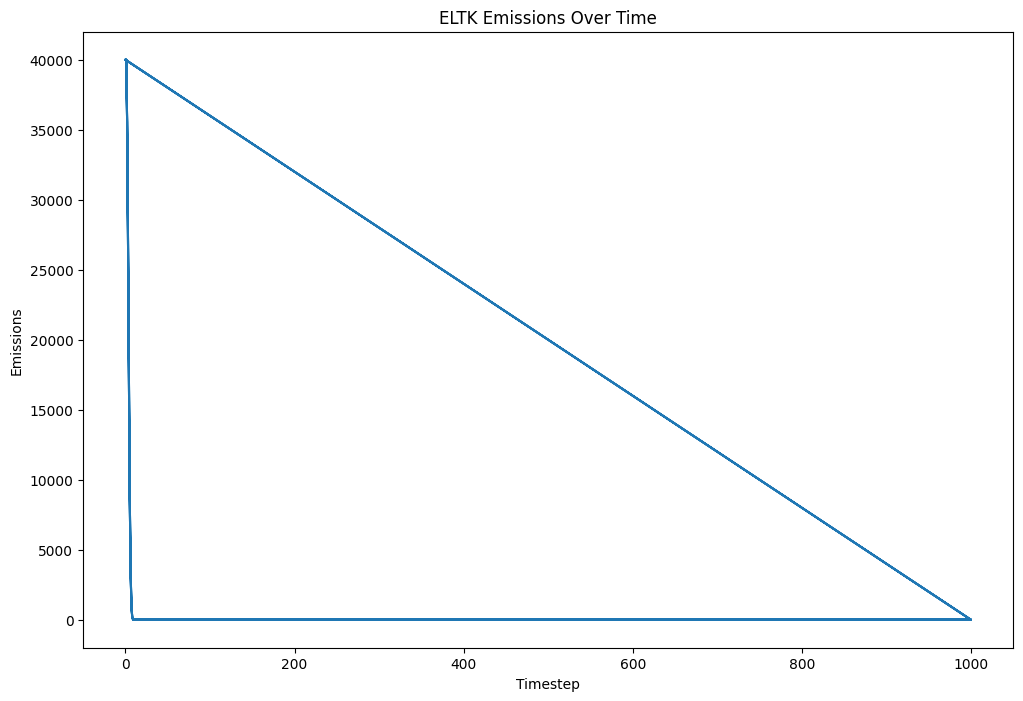

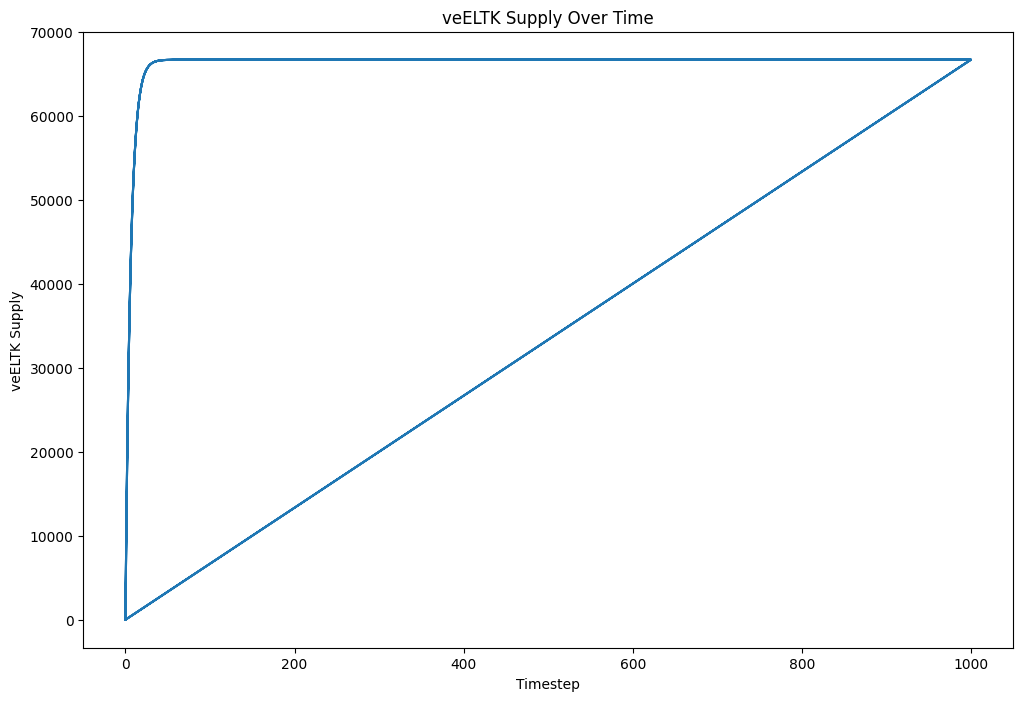

In [2]:
import matplotlib.pyplot as plt

# Plot ELTK emissions over time
plt.figure(figsize=(12, 8))
plt.plot(df['timestep'], df['emissions'])
plt.title('ELTK Emissions Over Time')
plt.xlabel('Timestep')
plt.ylabel('Emissions')
plt.show()

# Plot veELTK supply over time
plt.figure(figsize=(12, 8))
plt.plot(df['timestep'], df['veELTK_supply'])
plt.title('veELTK Supply Over Time')
plt.xlabel('Timestep')
plt.ylabel('veELTK Supply')
plt.show()


In [7]:
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

# Initial state
state = {
    'ELTK_supply': 100000,
    'veELTK_supply': 0,
    'liquidity_providers': 500,
    'emissions': 40000,
    'lock_period': 0,
    'current_time': 0,
    'volume': 100000,
    'tvl': 1000000,
}

# Simulation parameters
params = {
    'stake_rate': [0.1],  # rate at which new stakes are added
    'unstake_rate': [0.05],  # rate at which stakes are removed
    'lock_period': [1],  # lock period in years
    'base_emission_rate': [10000],  # base amount of emissions per epoch
    'dex_volume': [1000000],  # volume of a comparative DEX
}

#Policy Functions
def policy_stake(params, step, history, current_state):
    # The amount staked is the stake rate times the current ELTK supply
    amount = params['stake_rate'] * current_state['ELTK_supply']
    return {'stake': amount}

def policy_unstake(params, step, history, current_state):
    # The amount unstaked is the unstake rate times the current veELTK supply
    amount = params['unstake_rate'] * current_state['veELTK_supply']
    return {'unstake': amount}

def policy_calculate_emissions(params, step, history, current_state):
    # The emissions are calculated based on the base emission rate, the volume, and the volume of a comparative DEX
    emissions = params['base_emission_rate'] * (1 + (current_state['volume'] / params['dex_volume']))
    return {'emissions': emissions}

def policy_calculate_rebase_amount(params, step, history, current_state):
    # The rebase amount is calculated based on the supply of veELTK and ELTK, and the total emissions
    rebase_amount = (current_state['veELTK_supply'] / current_state['ELTK_supply'])**3 * 0.5 * current_state['emissions']
    return {'rebase_amount': rebase_amount}

#... you will need to add more policies here for TVL and volume growth, and to update the state variables accordingly ...

# Update functions
def update_ELTK_supply(params, step, sL, s, _input):
    y = 'ELTK_supply'
    x = s[y]
    # ELTK is staked (reducing the supply) and unstaked (increasing the supply)
    x = x - _input['stake'] + _input['unstake']
    # Emissions are added to the ELTK supply
    x = x + _input['emissions']
    return (y, x)

def update_veELTK_supply(params, step, sL, s, _input):
    y = 'veELTK_supply'
    x = s[y]
    # veELTK is created when ELTK is staked (increasing the supply) and destroyed when it is unstaked (reducing the supply)
    x = x + _input['stake'] - _input['unstake']
    # The rebase amount is added to the veELTK supply
    x = x + _input['rebase_amount']
    return (y, x)

#... and you will need to add more update functions here for emissions, volume, and TVL...

# Partial state update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'stake': policy_stake,
            'unstake': policy_unstake,
            'emissions': policy_calculate_emissions,
            'rebase_amount': policy_calculate_rebase_amount,
            #... and more policies here...
        },
        'variables': {
            'ELTK_supply': update_ELTK_supply,
            'veELTK_supply': update_veELTK_supply,
            #... and more variables here...
        }
    }
]

# Simulation parameters
sim_config = {
    'N': 5,  # number of Monte Carlo runs
    'T': range(1000),  # number of timesteps
    'M': params  # model parameters
}

sim_params = config_sim(sim_config)

# Configuring and running the simulation
exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 5, 5, 8)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 5, 5, 8)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 6.22s


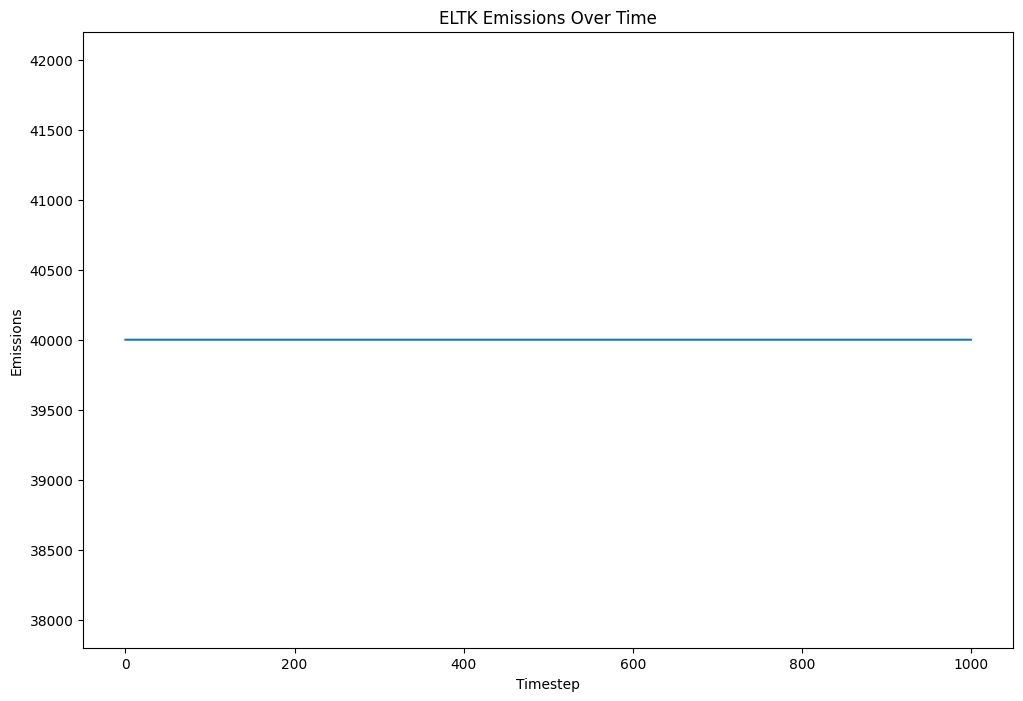

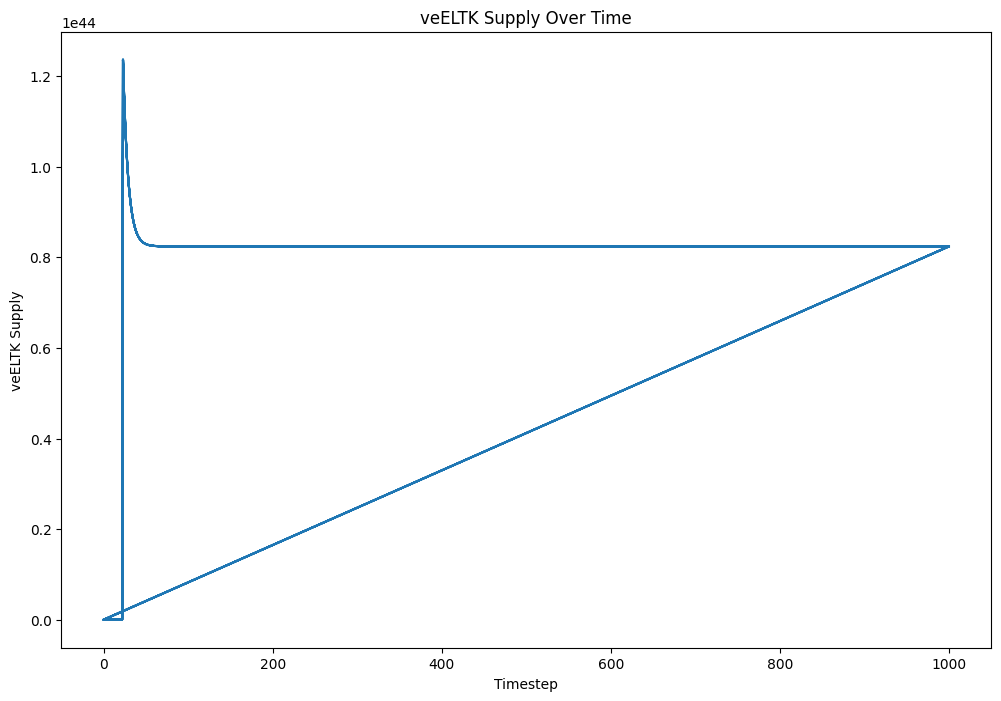

In [8]:
import matplotlib.pyplot as plt

# Plot ELTK emissions over time
plt.figure(figsize=(12, 8))
plt.plot(df['timestep'], df['emissions'])
plt.title('ELTK Emissions Over Time')
plt.xlabel('Timestep')
plt.ylabel('Emissions')
plt.show()

# Plot veELTK supply over time
plt.figure(figsize=(12, 8))
plt.plot(df['timestep'], df['veELTK_supply'])
plt.title('veELTK Supply Over Time')
plt.xlabel('Timestep')
plt.ylabel('veELTK Supply')
plt.show()


In [9]:
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

# Initial state
state = {
    'circulating_ELTK': 100000,
    'staked_ELTK': 0,
    'veELTK_supply': 0,
    'lock_period': 0,
    'current_time': 0,
    'volume': 100000,
    'tvl': 1000000,
}

# Simulation parameters
params = {
    'stake_rate': [0.1],  # rate at which new stakes are added
    'unstake_rate': [0.05],  # rate at which stakes are removed
    'lock_period': [1, 2, 3, 4],  # lock period in years
    'base_emission_rate': [10000],  # base amount of emissions per epoch
    'dex_volume': [1000000],  # volume of a comparative DEX
}

#Policy Functions
def policy_stake(params, step, history, current_state):
    # The amount staked is the stake rate times the current circulating ELTK
    amount = params['stake_rate'] * current_state['circulating_ELTK']
    return {'stake': amount}

def policy_unstake(params, step, history, current_state):
    # The amount unstaked is the unstake rate times the current staked ELTK
    amount = params['unstake_rate'] * current_state['staked_ELTK']
    return {'unstake': amount}

def policy_calculate_emissions(params, step, history, current_state):
    # The emissions are calculated based on the base emission rate, the volume, and the volume of a comparative DEX
    emissions = params['base_emission_rate'] * (1 + (current_state['volume'] / params['dex_volume']))
    return {'emissions': emissions}

def policy_calculate_rebase_amount(params, step, history, current_state):
    # The rebase amount is calculated based on the supply of veELTK and circulating ELTK, and the total emissions
    rebase_amount = (current_state['veELTK_supply'] / current_state['circulating_ELTK'])**3 * 0.5 * current_state['emissions']
    return {'rebase_amount': rebase_amount}

#... you will need to add more policies here for TVL and volume growth, and to update the state variables accordingly ...

# Update functions
def update_circulating_ELTK(params, step, sL, s, _input):
    y = 'circulating_ELTK'
    x = s[y]
    # ELTK is staked (reducing the circulating supply) and unstaked (increasing the circulating supply)
    x = x - _input['stake'] + _input['unstake']
    # Emissions are added to the circulating ELTK supply
    x = x + _input['emissions']
    return (y, x)

def update_staked_ELTK(params, step, sL, s, _input):
    y = 'staked_ELTK'
    x = s[y]
    # ELTK is staked (increasing the staked ELTK) and unstaked (reducing the staked ELTK)
    x = x + _input['stake'] - _input['unstake']
    return (y, x)

def update_veELTK_supply(params, step, sL, s, _input):
    y = 'veELTK_supply'
    x = s[y]
    # veELTK is created when ELTK is staked (increasing the supply)
    x = x + _input['stake']
    # The rebase amount is added to the veELTK supply
    x = x + _input['rebase_amount']
    return (y, x)

#... and you will need to add more update functions here for emissions, volume, and TVL...

# Partial state update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'stake': policy_stake,
            'unstake': policy_unstake,
            'emissions': policy_calculate_emissions,
            'rebase_amount': policy_calculate_rebase_amount,
            #... and more policies here...
        },
        'variables': {
            'circulating_ELTK': update_circulating_ELTK,
            'staked_ELTK': update_staked_ELTK,
            'veELTK_supply': update_veELTK_supply,
            #... and more variables here...
        }
    }
]


# Simulation parameters
sim_config = {
    'N': 5,  # number of Monte Carlo runs
    'T': range(1000),  # number of timesteps
    'M': params  # model parameters
}

sim_params = config_sim(sim_config)

# Configuring and running the simulation
exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 5, 20, 7)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 5, 20, 7)
Execution Method: local_simulations
Execution Mode: parallelized


KeyError: 'emissions'

## ROI
ROI= APY x t/T

Calcualte Average ROI of top 10 Uniswap pools

Take top 10 uniswap pools and and calculate their aberage ROI (tvl/fee) of past 10 months 
Compare that with our pool  

In [22]:
import numpy as np
import pandas as pd
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

# Initial state
initial_state = {
    'LP_ROI': 0,
    'swap_fees': 1000,  # Total swap fees generated in dollar - 1% of tvl
    'emissions': 100,  # Total emissions distributed to LPs dollar - 10% of TVL
    'tvl': 10000  # Total value of tokens provided by LPs as liquidity
}

# System parameters
system_params = {
    'fee_share_values': [0.3,0.4, 0.5, 0.6, 0.7],  # Different fee share values to test
}

# Policy function
def calculate_LP_ROI(params, step, sL, s):
    # The ROI for LPs is the sum of the swap fees (proportional to the fee share) and emissions, divided by the LP investment
    ROI = (params['fee_share_values'] * s['swap_fees'] + s['emissions']) / s['tvl']
    return {'ROI': ROI}

# State update function
def update_LP_ROI(params, step, sL, s, _input):
    return 'LP_ROI', _input['ROI']

# Partial state update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'ROI': calculate_LP_ROI
        },
        'variables': {
            'LP_ROI': update_LP_ROI
        }
    }
]

# Simulation configuration
sim_config = config_sim({
    'N': 1,  # number of Monte Carlo runs
    'T': range(1),#range(len(system_params['fee_share_values'])),  # number of timesteps
    'M': system_params  # model parameters
})

# Configuring and running the simulation
exp = Experiment()
exp.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1, 1, 5, 4)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1, 1, 5, 4)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 6.06s


In [11]:
df

,LP_ROI,fee_share,swap_fees,emissions,LP_investment,simulation,subset,run,substep,timestep
0,0.00,0.5,1000,100,10000,0,0,1,0,0
1,0.06,0.5,1000,100,10000,0,0,1,1,1
2,0.06,0.5,1000,100,10000,0,0,1,1,2
3,0.06,0.5,1000,100,10000,0,0,1,1,3
4,0.06,0.5,1000,100,10000,0,0,1,1,4
5,0.00,0.5,1000,100,10000,0,1,2,0,0
6,0.06,0.5,1000,100,10000,0,1,2,1,1
7,0.06,0.5,1000,100,10000,0,1,2,1,2
8,0.06,0.5,1000,100,10000,0,1,2,1,3
9,0.06,0.5,1000,100,10000,0,1,2,1,4


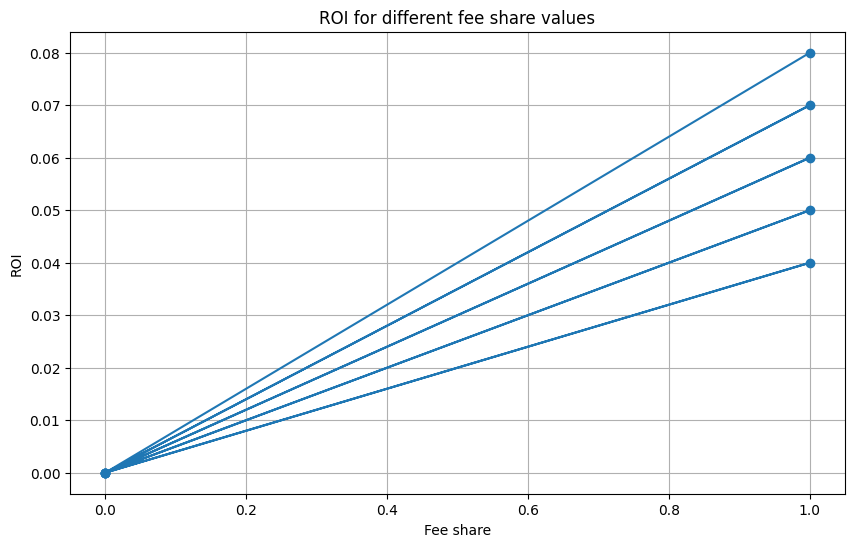

In [23]:
import matplotlib.pyplot as plt

# Plotting the ROI for different fee share values
plt.figure(figsize=(10,6))
plt.plot(df['timestep'], df['LP_ROI'], marker='o')
plt.xlabel('Fee share')
plt.ylabel('ROI')
plt.title('ROI for different fee share values')
#plt.xticks(df['timestep'], system_params['fee_share_values'])
plt.grid(True)
plt.show()

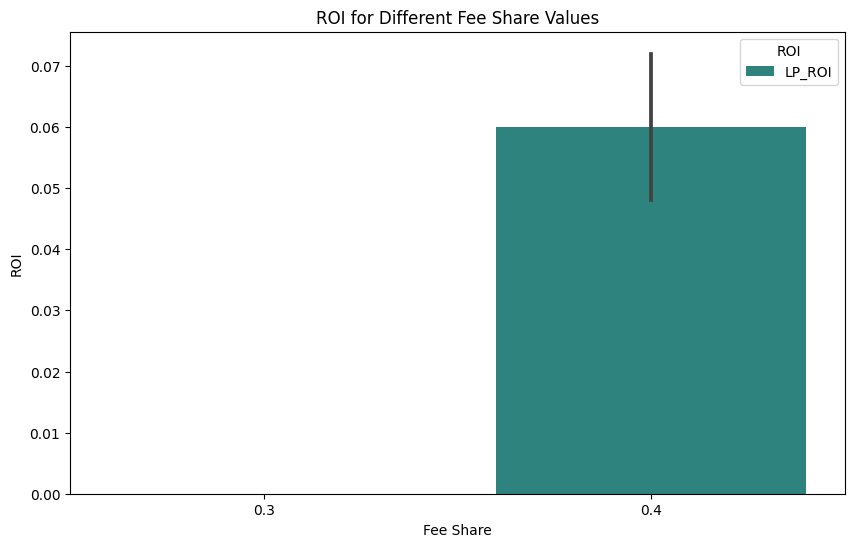

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess dataframe for plotting
df_plot = df.melt(id_vars=["timestep"], value_vars=["LP_ROI"], var_name="ROI")

# Create a new column for fee share values
df_plot["Fee Share"] = df_plot["timestep"].map(dict(enumerate(system_params['fee_share_values'])))

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Fee Share", y="value", hue="ROI", palette="viridis")
plt.title("ROI for Different Fee Share Values")
plt.ylabel("ROI")
plt.show()


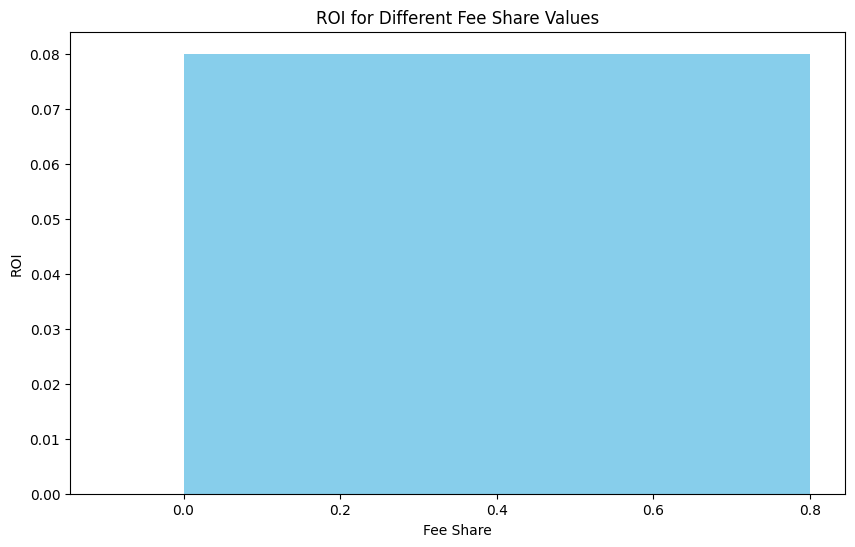

In [25]:
import matplotlib.pyplot as plt

# Mapping fee share values to timesteps
df['fee_share'] = df['timestep'].map(dict(enumerate(system_params['fee_share_values'])))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['fee_share'], df['LP_ROI'], color='skyblue')
plt.title('ROI for Different Fee Share Values')
plt.xlabel('Fee Share')
plt.ylabel('ROI')
plt.show()
